In [1]:
"""
Encoder-Decoder Architecture for Neural Machine Translation
============================================================
Implements sequence-to-sequence model for translation tasks using LSTM-based
encoder-decoder architecture with attention mechanism.

This will be split into 3 notebooks:
1. encoder_decoder.ipynb - Basic Seq2Seq (THIS FILE)
2. attention_mechanism.ipynb - Adding attention
3. translation_demo.ipynb - Full translation pipeline
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import re
from collections import Counter
# ==============================================================
# Ensure the SequentialModeling directory is discoverable
# ==============================================================

# Get current working directory
current_dir = os.getcwd()

# Check if SequentialModeling folder exists in current directory
if not os.path.exists(os.path.join(current_dir, "SequentialModeling")):
    # If not, assume notebook is in a subfolder (like notebooks/)
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
else:
    project_root = current_dir

# Add project root to system path (for imports)
if project_root not in sys.path:
    sys.path.append(project_root)

# ==============================================================
# Import LSTM implementations from SequentialModeling/layers.py
# ==============================================================

try:
    from SequentialModeling.layers import LSTMCell, LSTM
    print("✓ Successfully imported LSTMCell and LSTM from SequentialModeling/layers.py")
except ImportError as e:
    print("⚠ ImportError: Could not import LSTMCell or LSTM.")
    print("  Make sure SequentialModeling/layers.py exists and contains both classes.")
    print("  Full error:", e)
    raise


✓ Successfully imported LSTMCell and LSTM from SequentialModeling/layers.py


In [2]:
# ==================== VOCABULARY & PREPROCESSING ====================

class Vocabulary:
    """Manages vocabulary for source and target languages."""
    
    def __init__(self, language: str):
        self.language = language
        self.token2idx = {}
        self.idx2token = {}
        self.token_counts = Counter()
        
        # Special tokens
        self.PAD_token = 0
        self.SOS_token = 1  # Start of sequence
        self.EOS_token = 2  # End of sequence
        self.UNK_token = 3  # Unknown token
        
        self.token2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2token = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.n_tokens = 4
    
    def add_sentence(self, sentence: str):
        """Add all tokens from sentence to vocabulary."""
        tokens = self.tokenize(sentence)
        for token in tokens:
            self.add_token(token)
    
    def add_token(self, token: str):
        """Add a single token to vocabulary."""
        self.token_counts[token] += 1
        if token not in self.token2idx:
            self.token2idx[token] = self.n_tokens
            self.idx2token[self.n_tokens] = token
            self.n_tokens += 1
    
    def tokenize(self, sentence: str) -> List[str]:
        """Simple whitespace tokenization with punctuation handling."""
        # Lowercase and basic tokenization
        sentence = sentence.lower()
        # Add space around punctuation
        sentence = re.sub(r'([.!?])', r' \1', sentence)
        tokens = sentence.split()
        return tokens
    
    def encode(self, sentence: str) -> List[int]:
        """Convert sentence to list of token indices."""
        tokens = self.tokenize(sentence)
        indices = [self.token2idx.get(token, self.UNK_token) for token in tokens]
        return indices
    
    def decode(self, indices: List[int], skip_special: bool = True) -> str:
        """Convert indices back to sentence."""
        tokens = []
        for idx in indices:
            if skip_special and idx in [self.PAD_token, self.SOS_token, self.EOS_token]:
                continue
            tokens.append(self.idx2token.get(idx, '<UNK>'))
        return ' '.join(tokens)

In [3]:
# ==================== ENCODER ====================

class Encoder:
    """
    LSTM-based encoder that processes source sequence.
    
    Input: Source sentence
    Output: Final hidden state (context vector) + all hidden states
    """
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int, seed: int = 42):
        """
        Initialize encoder.
        
        Args:
            vocab_size: Size of source vocabulary
            embedding_dim: Dimension of embeddings
            hidden_size: Size of LSTM hidden state
        """
        np.random.seed(seed)
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # Embedding layer
        self.embeddings = np.random.randn(vocab_size, embedding_dim) * 0.01
        
        # LSTM cell
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size, seed)
        
    def forward(self, input_indices: List[int]) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray]]:
        """
        Forward pass through encoder.
        
        Args:
            input_indices: List of token indices from source sentence
            
        Returns:
            final_hidden: Final hidden state (context vector)
            final_cell: Final cell state
            all_hidden: All hidden states (for attention later)
        """
        seq_length = len(input_indices)
        
        # Initialize states
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        all_hidden = []
        
        # Process each token
        for t in range(seq_length):
            # Get embedding
            token_idx = input_indices[t]
            x = self.embeddings[token_idx].reshape(-1, 1)
            
            # LSTM step
            h, c = self.lstm_cell.forward(x, h, c)
            all_hidden.append(h.copy())
        
        return h, c, all_hidden



In [4]:
# ==================== DECODER ====================

class Decoder:
    """
    LSTM-based decoder that generates target sequence.
    
    Input: Context vector from encoder + previous token
    Output: Next token prediction
    """
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int, seed: int = 42):
        """
        Initialize decoder.
        
        Args:
            vocab_size: Size of target vocabulary
            embedding_dim: Dimension of embeddings
            hidden_size: Size of LSTM hidden state (should match encoder)
        """
        np.random.seed(seed)
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # Embedding layer
        self.embeddings = np.random.randn(vocab_size, embedding_dim) * 0.01
        
        # LSTM cell
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size, seed)
        
        # Output layer (hidden state -> vocabulary probabilities)
        self.W_out = np.random.randn(vocab_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_out = np.zeros((vocab_size, 1))
        
    def forward_step(self, token_idx: int, h: np.ndarray, c: np.ndarray) -> Tuple:
        """
        Single decoder step.
        
        Args:
            token_idx: Previous token index
            h: Previous hidden state
            c: Previous cell state
            
        Returns:
            logits: Output logits over vocabulary
            h_next: Next hidden state
            c_next: Next cell state
        """
        # Get embedding
        x = self.embeddings[token_idx].reshape(-1, 1)
        
        # LSTM step
        h_next, c_next = self.lstm_cell.forward(x, h, c)
        
        # Output projection
        logits = self.W_out @ h_next + self.b_out
        
        return logits, h_next, c_next
    
    def forward(self, target_indices: List[int], encoder_hidden: np.ndarray,
                encoder_cell: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Forward pass through entire target sequence (training mode).
        
        Args:
            target_indices: Target sequence indices (with <SOS> prepended)
            encoder_hidden: Initial hidden state from encoder
            encoder_cell: Initial cell state from encoder
            
        Returns:
            all_logits: Logits for each time step
            all_hidden: Hidden states for each time step
        """
        h = encoder_hidden
        c = encoder_cell
        
        all_logits = []
        all_hidden = []
        
        # Teacher forcing: use ground truth tokens as input
        for t in range(len(target_indices) - 1):
            token_idx = target_indices[t]
            logits, h, c = self.forward_step(token_idx, h, c)
            
            all_logits.append(logits)
            all_hidden.append(h)
        
        return all_logits, all_hidden


In [5]:
# ==================== SEQ2SEQ MODEL ====================

class Seq2Seq:
    """Complete sequence-to-sequence model."""
    
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 embedding_dim: int, hidden_size: int, learning_rate: float = 0.01):
        """
        Initialize Seq2Seq model.
        
        Args:
            src_vocab_size: Source vocabulary size
            tgt_vocab_size: Target vocabulary size
            embedding_dim: Embedding dimension
            hidden_size: Hidden state size
            learning_rate: Learning rate for training
        """
        self.encoder = Encoder(src_vocab_size, embedding_dim, hidden_size)
        self.decoder = Decoder(tgt_vocab_size, embedding_dim, hidden_size)
        
        self.learning_rate = learning_rate
        self.loss_history = []
        
    def softmax(self, x):
        """Numerically stable softmax."""
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    def compute_loss(self, logits_list: List[np.ndarray], target_indices: List[int]) -> float:
        """Compute cross-entropy loss."""
        loss = 0
        for logits, target_idx in zip(logits_list, target_indices[1:]):  # Skip <SOS>
            probs = self.softmax(logits)
            loss += -np.log(probs[target_idx, 0] + 1e-10)
        return loss / len(logits_list)
    
    def train_step(self, src_indices: List[int], tgt_indices: List[int]) -> float:
        """
        Single training step.
        
        Args:
            src_indices: Source sequence indices
            tgt_indices: Target sequence indices (should include <SOS> and <EOS>)
        """
        # Encode source
        enc_hidden, enc_cell, _ = self.encoder.forward(src_indices)
        
        # Decode target
        logits_list, _ = self.decoder.forward(tgt_indices, enc_hidden, enc_cell)
        
        # Compute loss
        loss = self.compute_loss(logits_list, tgt_indices)
        
        # Simplified gradient update (approximate)
        for i, (logits, target_idx) in enumerate(zip(logits_list, tgt_indices[1:])):
            probs = self.softmax(logits)
            dlogits = probs.copy()
            dlogits[target_idx, 0] -= 1
            
            # Clip gradients
            dlogits = np.clip(dlogits, -5, 5)
            
            # Update decoder output layer
            self.decoder.W_out -= self.learning_rate * dlogits * 0.001
            self.decoder.b_out -= self.learning_rate * dlogits * 0.001
        
        self.loss_history.append(loss)
        return loss
    
    def translate(self, src_indices: List[int], tgt_vocab: Vocabulary,
                  max_length: int = 20, method: str = 'greedy') -> List[int]:
        """
        Translate source sequence to target sequence.
        
        Args:
            src_indices: Source sequence indices
            tgt_vocab: Target vocabulary
            max_length: Maximum length of translation
            method: 'greedy' or 'sample'
            
        Returns:
            predicted_indices: Predicted target sequence
        """
        # Encode source
        enc_hidden, enc_cell, _ = self.encoder.forward(src_indices)
        
        # Initialize decoder with <SOS>
        h = enc_hidden
        c = enc_cell
        predicted_indices = [tgt_vocab.SOS_token]
        
        # Generate tokens one by one
        for _ in range(max_length):
            # Decoder step
            logits, h, c = self.decoder.forward_step(predicted_indices[-1], h, c)
            
            # Get next token
            if method == 'greedy':
                next_token = np.argmax(logits)
            else:  # sample
                probs = self.softmax(logits)
                next_token = np.random.choice(len(probs), p=probs[:, 0])
            
            predicted_indices.append(next_token)
            
            # Stop if <EOS> generated
            if next_token == tgt_vocab.EOS_token:
                break
        
        return predicted_indices

In [6]:
# ==================== DATA PREPARATION ====================

def load_translation_pairs() -> List[Tuple[str, str]]:
    """
    Load sample translation pairs (English -> French).
    In practice, you'd load from a real dataset.
    """
    pairs = [
        ("hello", "bonjour"),
        ("goodbye", "au revoir"),
        ("thank you", "merci"),
        ("how are you", "comment allez vous"),
        ("good morning", "bonjour"),
        ("good night", "bonne nuit"),
        ("i love you", "je t aime"),
        ("what is your name", "comment vous appelez vous"),
        ("my name is john", "je m appelle john"),
        ("where is the station", "ou est la gare"),
        ("i am hungry", "j ai faim"),
        ("i am tired", "je suis fatigue"),
        ("yes", "oui"),
        ("no", "non"),
        ("please", "s il vous plait"),
        ("excuse me", "excusez moi"),
        ("i do not understand", "je ne comprends pas"),
        ("how much", "combien"),
        ("where", "ou"),
        ("when", "quand"),
        ("what", "quoi"),
        ("who", "qui"),
        ("why", "pourquoi"),
        ("how", "comment"),
    ]
    return pairs



In [7]:

# ==================== VISUALIZATION ====================

def visualize_training(model: Seq2Seq, src_vocab: Vocabulary, tgt_vocab: Vocabulary,
                       test_pairs: List[Tuple[str, str]]):
    """Visualize training progress and translation examples."""
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Loss curve
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(model.loss_history, linewidth=2, color='#3b82f6', alpha=0.8)
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss (Seq2Seq without Attention)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Translation examples
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.axis('off')
    
    example_text = "📝 Translation Examples\n" + "="*50 + "\n\n"
    for i, (src, tgt) in enumerate(test_pairs[:8], 1):
        src_indices = src_vocab.encode(src)
        predicted_indices = model.translate(src_indices, tgt_vocab, max_length=15)
        predicted = tgt_vocab.decode(predicted_indices)
        
        example_text += f"{i}. EN: {src}\n"
        example_text += f"   FR: {tgt}\n"
        example_text += f"   Predicted: {predicted}\n\n"
    
    ax2.text(0.05, 0.95, example_text, fontsize=8, family='monospace',
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    # Plot 3: Architecture diagram
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    
    arch_text = """
    🏗️ Encoder-Decoder Architecture
    
    ENCODER:
    ┌──────────────────┐
    │ Source Sentence  │
    │  "hello world"   │
    └────────┬─────────┘
             │ Embed
             ▼
    ┌──────────────────┐
    │  LSTM Encoder    │
    │  h₁ → h₂ → h₃   │
    └────────┬─────────┘
             │ Context Vector
             │ (final hidden state)
             ▼
    DECODER:
    ┌──────────────────┐
    │  LSTM Decoder    │
    │  <SOS>→h₁→h₂→..  │
    └────────┬─────────┘
             │ Softmax
             ▼
    ┌──────────────────┐
    │ Target Sentence  │
    │ "bonjour monde"  │
    └──────────────────┘
    
    ⚠️  Bottleneck: All source info
       compressed into single vector!
       → Attention fixes this
    """
    
    ax3.text(0.5, 0.5, arch_text, fontsize=9, family='monospace',
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.savefig('encoder_decoder_results.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'encoder_decoder_results.png'")
    plt.show()

ENCODER-DECODER FOR NEURAL MACHINE TRANSLATION

📋 Configuration:
   Task: English → French
   Embedding Dimension: 32
   Hidden Size: 64
   Learning Rate: 0.01
   Epochs: 500

📚 Loading translation pairs...
   Total pairs: 24
   Sample: ('hello', 'bonjour')

🔤 Building vocabularies...
   Source vocab size: 39
   Target vocab size: 44

🧠 Initializing Seq2Seq model...

🚀 Training model...
----------------------------------------------------------------------
Epoch  50/500 | Avg Loss: 3.7802
Epoch 100/500 | Avg Loss: 3.7760
Epoch 150/500 | Avg Loss: 3.7719
Epoch 200/500 | Avg Loss: 3.7677
Epoch 250/500 | Avg Loss: 3.7636
Epoch 300/500 | Avg Loss: 3.7595
Epoch 350/500 | Avg Loss: 3.7554
Epoch 400/500 | Avg Loss: 3.7513
Epoch 450/500 | Avg Loss: 3.7472
Epoch 500/500 | Avg Loss: 3.7431
----------------------------------------------------------------------
✓ Training complete!

📝 Translation Examples:

1. [✗] Source (EN):    hello
          Target (FR):    bonjour
          Predicted (FR): 
-

C:\Users\amrHa\AppData\Local\Temp\ipykernel_28700\3738570817.py:78: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('encoder_decoder_results.png', dpi=300, bbox_inches='tight')
C:\Users\amrHa\AppData\Local\Temp\ipykernel_28700\3738570817.py:78: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('encoder_decoder_results.png', dpi=300, bbox_inches='tight')
C:\Users\amrHa\AppData\Local\Temp\ipykernel_28700\3738570817.py:78: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('encoder_decoder_results.png', dpi=300, bbox_inches='tight')


✓ Visualization saved as 'encoder_decoder_results.png'


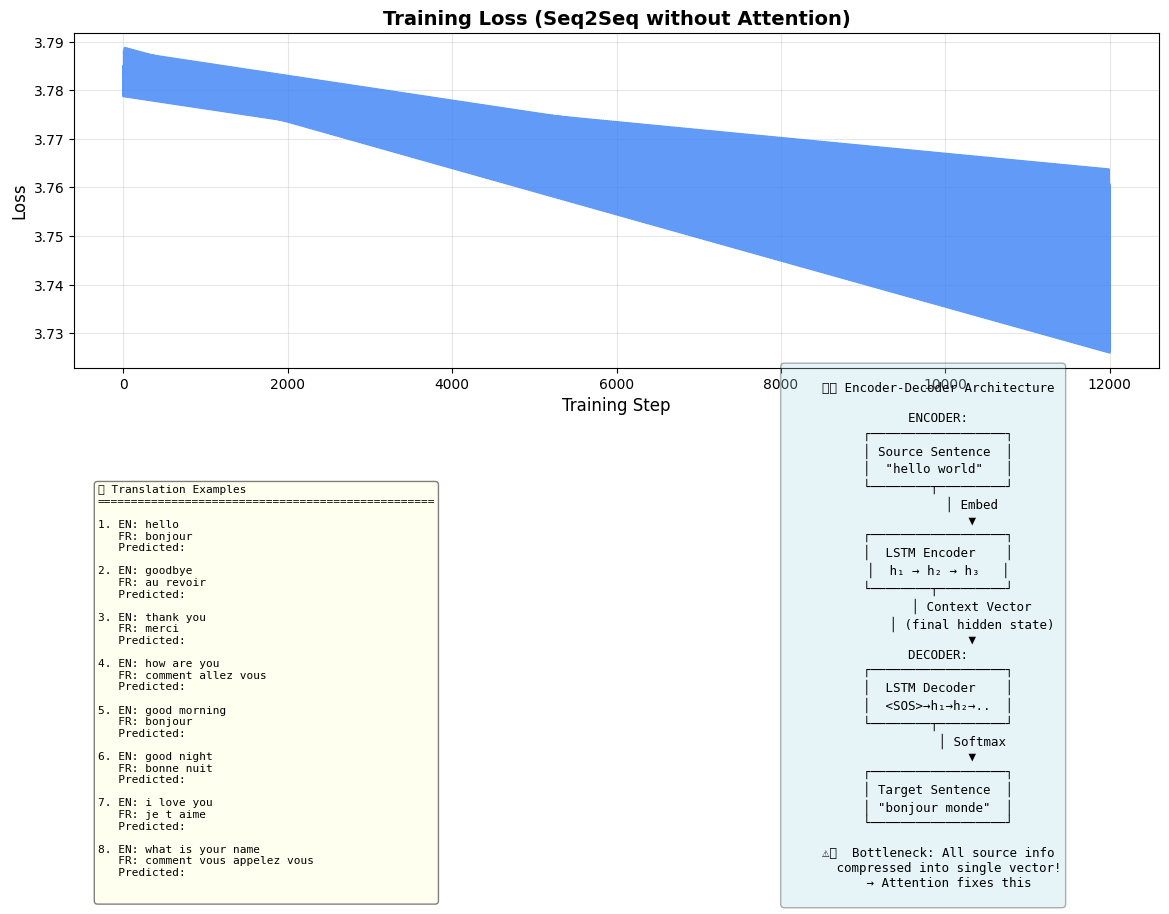


KEY CONCEPTS:
----------------------------------------------------------------------
1. Encoder: Compresses source sentence into context vector
2. Decoder: Generates target sentence from context vector
3. Bottleneck Problem: Single vector must encode entire meaning
4. Teacher Forcing: Use ground truth as decoder input during training
5. Next: Attention mechanism solves the bottleneck problem!

DEMONSTRATION COMPLETE!


In [12]:
# ==================== MAIN DEMONSTRATION ====================

def main():
    """Main demonstration of encoder-decoder translation."""
    
    print("=" * 70)
    print("ENCODER-DECODER FOR NEURAL MACHINE TRANSLATION")
    print("=" * 70)
    
    # Configuration
    embedding_dim = 32
    hidden_size = 64
    learning_rate = 0.01
    epochs = 500
    
    print("\n📋 Configuration:")
    print(f"   Task: English → French")
    print(f"   Embedding Dimension: {embedding_dim}")
    print(f"   Hidden Size: {hidden_size}")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   Epochs: {epochs}")
    
    # Load data
    print("\n📚 Loading translation pairs...")
    pairs = load_translation_pairs()
    print(f"   Total pairs: {len(pairs)}")
    print(f"   Sample: {pairs[0]}")
    
    # Build vocabularies
    print("\n🔤 Building vocabularies...")
    src_vocab = Vocabulary('english')
    tgt_vocab = Vocabulary('french')
    
    for src, tgt in pairs:
        src_vocab.add_sentence(src)
        tgt_vocab.add_sentence(tgt)
    
    print(f"   Source vocab size: {src_vocab.n_tokens}")
    print(f"   Target vocab size: {tgt_vocab.n_tokens}")
    
    # Initialize model
    print("\n🧠 Initializing Seq2Seq model...")
    model = Seq2Seq(
        src_vocab_size=src_vocab.n_tokens,
        tgt_vocab_size=tgt_vocab.n_tokens,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        learning_rate=learning_rate
    )
    
    # Training
    print("\n🚀 Training model...")
    print("-" * 70)
    
    for epoch in range(epochs):
        total_loss = 0
        
        # Train on all pairs
        for src, tgt in pairs:
            src_indices = src_vocab.encode(src)
            tgt_indices = [tgt_vocab.SOS_token] + tgt_vocab.encode(tgt) + [tgt_vocab.EOS_token]
            
            loss = model.train_step(src_indices, tgt_indices)
            total_loss += loss
        
        avg_loss = total_loss / len(pairs)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1:3d}/{epochs} | Avg Loss: {avg_loss:.4f}")
    
    print("-" * 70)
    print("✓ Training complete!")
    
    # Evaluation
    print("\n📝 Translation Examples:")
    print("=" * 70)
    
    test_pairs = pairs[:10]
    correct = 0
    for i, (src, tgt) in enumerate(test_pairs, 1):
        src_indices = src_vocab.encode(src)
        predicted_indices = model.translate(src_indices, tgt_vocab, max_length=15)
        predicted = tgt_vocab.decode(predicted_indices)
        
        # Check if correct
        is_correct = predicted.strip().lower() == tgt.strip().lower()
        if is_correct:
            correct += 1
        
        status = "✓" if is_correct else "✗"
        print(f"\n{i}. [{status}] Source (EN):    {src}")
        print(f"          Target (FR):    {tgt}")
        print(f"          Predicted (FR): {predicted}")
        print("-" * 70)
    
    print(f"\nAccuracy: {correct}/{len(test_pairs)} = {100*correct/len(test_pairs):.1f}%")
    

    
    # Visualize
    print("\n📊 Generating visualizations...")
    visualize_training(model, src_vocab, tgt_vocab, test_pairs)
    
    print("\n" + "=" * 70)
    print("KEY CONCEPTS:")
    print("-" * 70)
    print("1. Encoder: Compresses source sentence into context vector")
    print("2. Decoder: Generates target sentence from context vector")
    print("3. Bottleneck Problem: Single vector must encode entire meaning")
    print("4. Teacher Forcing: Use ground truth as decoder input during training")
    print("5. Next: Attention mechanism solves the bottleneck problem!")
    print("=" * 70)
    print("\nDEMONSTRATION COMPLETE!")
    print("=" * 70)


if __name__ == "__main__":
    main()

In [11]:
# Explain the bottleneck problem
print("\n" + "!" * 70)
print("⚠️  BOTTLENECK PROBLEM DEMONSTRATION")
print("!" * 70)
print("\nWhy is performance so poor?")
print("-" * 70)
print("❌ The entire source sentence is compressed into a SINGLE vector")
print("❌ Long sentences lose information (everything squeezed into fixed size)")
print("❌ Decoder can't access specific source words when needed")
print("❌ No way to 'look back' at relevant parts of input")
print("\n💡 SOLUTION: Attention Mechanism!")
print("   → Decoder can focus on different source words at each step")
print("   → All encoder hidden states available, not just the last one")
print("   → See attention_mechanism.ipynb for the fix!")
print("!" * 70)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
⚠️  BOTTLENECK PROBLEM DEMONSTRATION
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Why is performance so poor?
----------------------------------------------------------------------
❌ The entire source sentence is compressed into a SINGLE vector
❌ Long sentences lose information (everything squeezed into fixed size)
❌ Decoder can't access specific source words when needed
❌ No way to 'look back' at relevant parts of input

💡 SOLUTION: Attention Mechanism!
   → Decoder can focus on different source words at each step
   → All encoder hidden states available, not just the last one
   → See attention_mechanism.ipynb for the fix!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
